## **Library**

In [1]:
import os
import re
import glob
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import soundfile as sf
from pathlib import Path
from collections import Counter
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras import Sequential, layers, models, regularizers, optimizers, callbacks, mixed_precision

seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [2]:
# check gpu availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# Parameters
SR = 22050               # sampling rate
DURATION = 4.0           # target duration (seconds) -> semua file akan dipotong / dipadatkan
N_MELS = 128             # mel bins (freq)
N_FFT = 2048
HOP_LENGTH = 512
EPS = 1e-6
BATCH_SIZE = 32
RANDOM_STATE = 42

## **Data**

In [4]:
# main path
project_root = Path(r"C:\Users\Salim\Kuliah\Semester 5\Jaringan Syaraf Tiruan\Project\Project-JST")
base_dir = str(project_root / "Data" / "IndoWaveSentiment")
output_base = str(project_root / "Data" / "IndoWaveSentiment_Augmented")

In [5]:
audio_folder = r"C:\Users\Salim\Kuliah\Semester 5\Jaringan Syaraf Tiruan\Project\Project-JST\Data\IndoWaveSentiment"

actor_dirs = [f'Actor_{str(i).zfill(2)}' for i in range(1, 11)]
wav_files = []
for actor in actor_dirs:
    actor_path = os.path.join(audio_folder, actor, '*.wav')
    wav_files.extend(glob.glob(actor_path))
print(f"Total WAV files found: {len(wav_files)}")

# load all audio files and print their durations
for file in wav_files[:5]:  # just load first 5 files for demonstration
    audio, sr = librosa.load(file, sr=None)
    duration = len(audio) / sr
    print(f"File: {os.path.basename(file)}, Duration: {duration:.2f} seconds, Sample Rate: {sr} Hz")

# Print statistics about all durations
print("\nLoading all audio files to analyze durations...")
all_durations = []
for file in wav_files:
    audio, sr = librosa.load(file, sr=None)
    duration = len(audio) / sr
    all_durations.append(duration)

print(f"\nDuration Statistics:")
print(f"Total files: {len(all_durations)}")
print(f"Min duration: {min(all_durations):.2f} seconds")
print(f"Max duration: {max(all_durations):.2f} seconds")
print(f"Mean duration: {np.mean(all_durations):.2f} seconds")
print(f"Median duration: {np.median(all_durations):.2f} seconds")

Total WAV files found: 300


c:\Users\loq\anaconda3\envs\tf-audio-gpu\lib\site-packages\librosa\core\intervals.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


File: 01-01-01-01.wav, Duration: 3.00 seconds, Sample Rate: 44100 Hz
File: 01-01-01-02.wav, Duration: 3.00 seconds, Sample Rate: 44100 Hz
File: 01-01-01-03.wav, Duration: 3.00 seconds, Sample Rate: 44100 Hz
File: 01-01-02-01.wav, Duration: 3.00 seconds, Sample Rate: 44100 Hz
File: 01-01-02-02.wav, Duration: 3.00 seconds, Sample Rate: 44100 Hz

Loading all audio files to analyze durations...

Duration Statistics:
Total files: 300
Min duration: 3.00 seconds
Max duration: 3.80 seconds
Mean duration: 3.10 seconds
Median duration: 3.00 seconds


In [6]:

# helper: load, pad/trim, compute log-mel spectrogram, normalize per-sample
def file_to_log_mel(path, sr=SR, duration=DURATION, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH):
    y, _sr = librosa.load(path, sr=sr, mono=True)

    # Trim leading/trailing silence (opsional)
    y, _ = librosa.effects.trim(y, top_db=25)

    # Pre-emphasis (opsional untuk menonjolkan frekuensi tinggi)
    y = np.append(y[0], y[1:] - 0.97 * y[:-1])

    target_len = int(sr * duration)
    if len(y) < target_len:
        y = librosa.util.fix_length(y, size=target_len)
    else:
        y = y[:target_len]

    mel = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length,
        n_mels=n_mels, power=2.0)
    log_mel = librosa.power_to_db(mel, ref=np.max)

    # Tidak ada normalisasi per-file di sini (akan dilakukan global setelah split)
    return log_mel.astype(np.float32)

## **Labelling**

In [7]:
# label dictionary
label_map = {
    '01': 'neutral',
    '02': 'happy',
    '03': 'surprise',
    '04': 'disgust',
    '05': 'disappointed'
}

# Update wav_files to include both original and augmented files
wav_files_original = []
for actor in actor_dirs:
    actor_path = os.path.join(audio_folder, actor, '*.wav')
    wav_files_original.extend(glob.glob(actor_path))

wav_files = wav_files_original
print(f"Total WAV files: {len(wav_files)}")

def label_from_filename(filename):
    """
    Extract emotion code from filename robustly.
    Finds the first 2-digit token in the name that matches label_map keys.
    """
    fname = os.path.basename(filename)
    match = re.search(r'-(\d{2})-', fname)
    if match:
        code = match.group(1)
        return label_map.get(code, None)
    return None

labels = [label_from_filename(f) for f in wav_files]
print(labels[:10])

Total WAV files: 300
['neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'happy', 'happy', 'happy', 'happy']


## **Exploratory Data Analysis**

### **Data Distributionn**


Overall Label Distribution:
disappointed   :  60 ( 20.0%) 
disgust        :  60 ( 20.0%) 
happy          :  60 ( 20.0%) 
neutral        :  60 ( 20.0%) 
surprise       :  60 ( 20.0%) 

Imbalance Ratio: 1.00:1
Distribusi cukup seimbang.


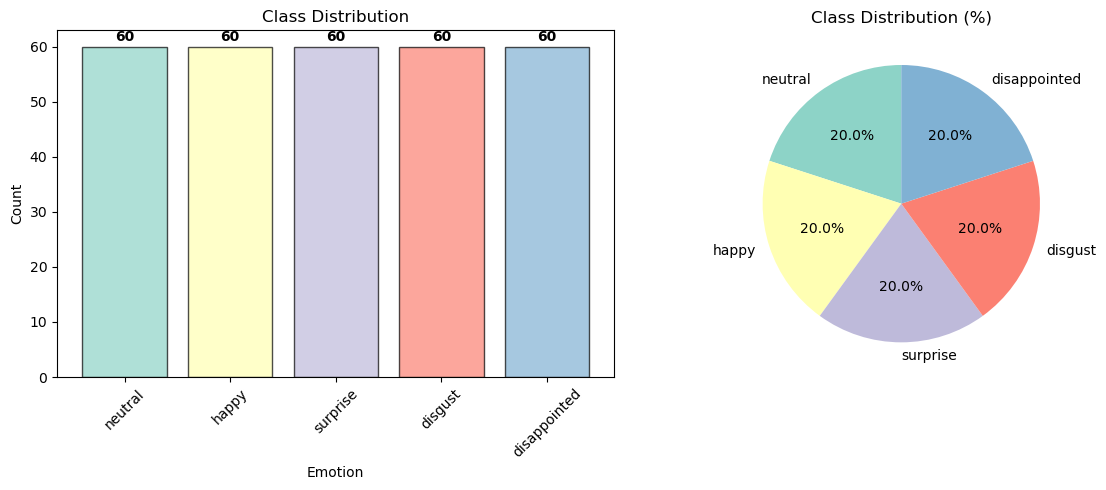

In [23]:
# Overall distribution of labels
label_counts = Counter(labels)
total_files = len(labels)

print("\nOverall Label Distribution:")
for emotion, count in sorted(label_counts.items()):
    percentage = 100 * count / total_files
    bar = "" * int(percentage / 2)
    print(f"{emotion:15s}: {count:3d} ({percentage:5.1f}%) {bar}")

# Check imbalance ratio
max_count = max(label_counts.values())
min_count = min(label_counts.values())
imbalance_ratio = max_count / min_count
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}:1")
if imbalance_ratio > 2.0:
    print(f"SEVERE IMBALANCE! Perlu handling khusus.")
elif imbalance_ratio > 1.5:
    print(f"MODERATE IMBALANCE. Gunakan class weights.")
else:
    print(f"Distribusi cukup seimbang.")

# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
emotions = list(label_counts.keys())
counts = list(label_counts.values())
colors = plt.cm.Set3(range(len(emotions)))
plt.bar(emotions, counts, color=colors, edgecolor='black', alpha=0.7)
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(rotation=45)
for i, (emotion, count) in enumerate(zip(emotions, counts)):
    plt.text(i, count + 1, str(count), ha='center', fontweight='bold')

plt.subplot(1, 2, 2)
plt.pie(counts, labels=emotions, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Class Distribution (%)')
plt.tight_layout()
plt.show()


Distribusi Per Actor:


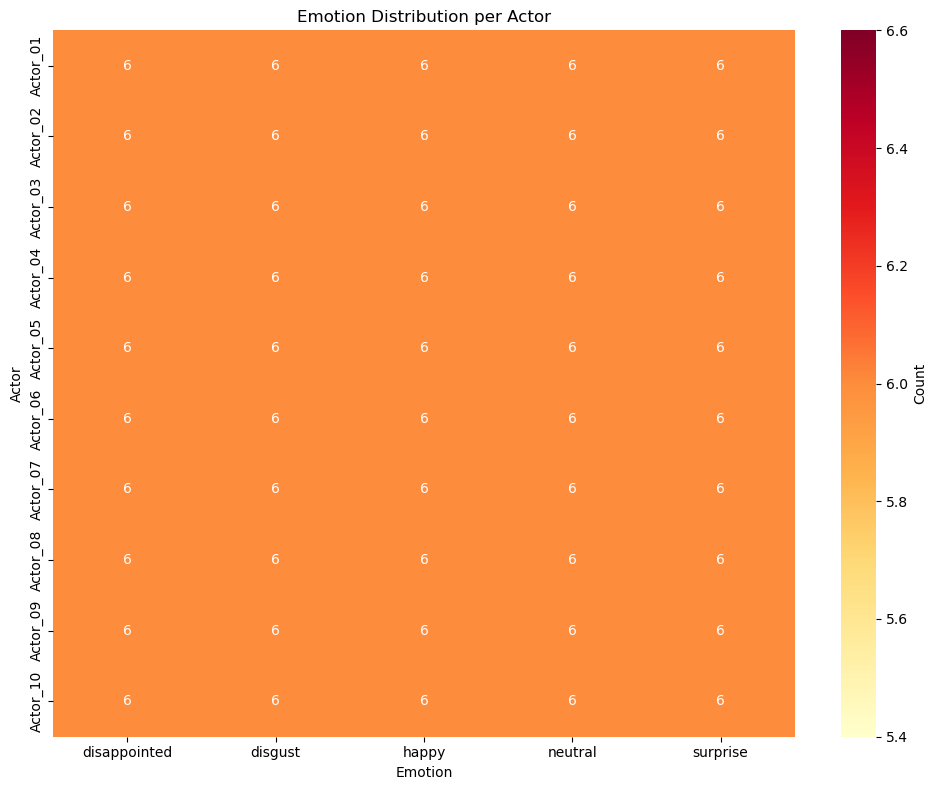


   Actor dengan Potensi Bias:
   Actor_01: Distribusi cukup seimbang.
   Actor_02: Distribusi cukup seimbang.
   Actor_03: Distribusi cukup seimbang.
   Actor_04: Distribusi cukup seimbang.
   Actor_05: Distribusi cukup seimbang.
   Actor_06: Distribusi cukup seimbang.
   Actor_07: Distribusi cukup seimbang.
   Actor_08: Distribusi cukup seimbang.
   Actor_09: Distribusi cukup seimbang.
   Actor_10: Distribusi cukup seimbang.


In [12]:
print("\nDistribusi Per Actor:")
actor_emotion_dist = {}
for fp in wav_files:
    actor = os.path.basename(os.path.dirname(fp))
    emotion = label_from_filename(fp)
    if actor not in actor_emotion_dist:
        actor_emotion_dist[actor] = []
    actor_emotion_dist[actor].append(emotion)

# Visualisasi heatmap
actor_emotion_matrix = []
actors = sorted(actor_emotion_dist.keys())
for actor in actors:
    emotions_count = Counter(actor_emotion_dist[actor])
    row = [emotions_count.get(emotion, 0) for emotion in sorted(label_map.values())]
    actor_emotion_matrix.append(row)

plt.figure(figsize=(10, 8))
sns.heatmap(actor_emotion_matrix, 
            annot=True, 
            fmt='d', 
            xticklabels=sorted(label_map.values()),
            yticklabels=actors,
            cmap='YlOrRd',
            cbar_kws={'label': 'Count'})
plt.xlabel('Emotion')
plt.ylabel('Actor')
plt.title('Emotion Distribution per Actor')
plt.tight_layout()
plt.show()

# Cek apakah ada actor dengan bias kelas tertentu
print("\n   Actor dengan Potensi Bias:")
for actor, emotions in actor_emotion_dist.items():
    emotion_counts = Counter(emotions)
    max_emotion = max(emotion_counts, key=emotion_counts.get)
    max_percentage = 100 * emotion_counts[max_emotion] / len(emotions)
    if max_percentage > 50:
        print(f"   ⚠️  {actor}: {max_percentage:.1f}% adalah '{max_emotion}'")
    else: 
        print(f"   {actor}: Distribusi cukup seimbang.")

### **Audio Characteristic**


Statistik Durasi Audio:
- Min   : 3.00 seconds
- Max   : 3.80 seconds
- Mean  : 3.10 seconds
- Median: 3.00 seconds
- Std   : 0.21 seconds


C:\Users\loq\AppData\Local\Temp\ipykernel_21036\2444362113.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([duration_by_class[emotion] for emotion in sorted(label_map.values())],


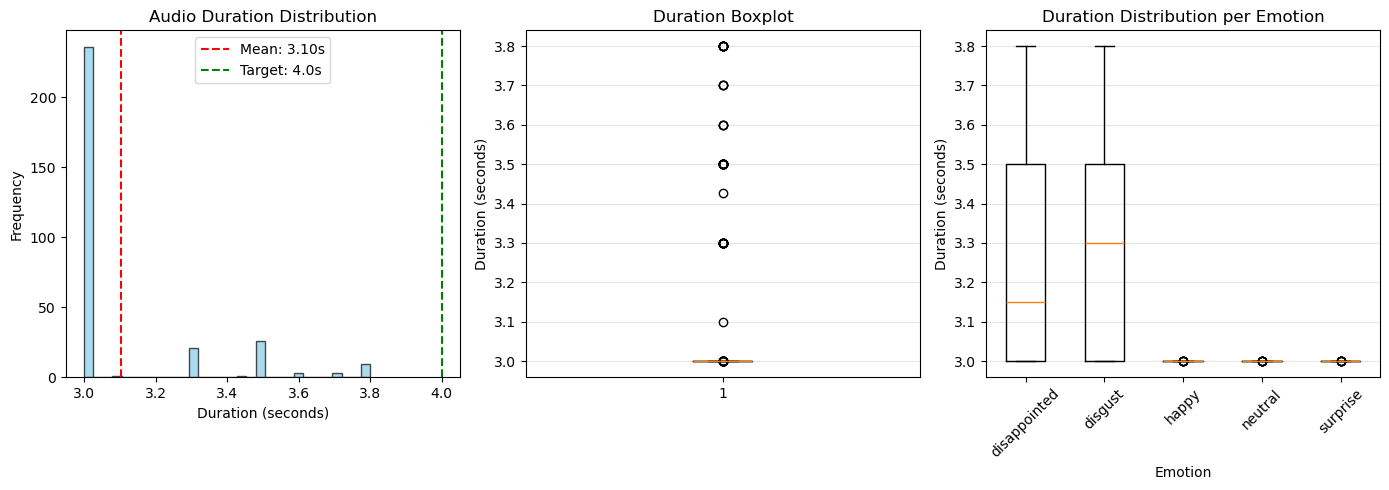


Files < 2.0s (perlu padding): 0
Files > 8.0s (akan di-crop): 0


In [21]:
print("\nStatistik Durasi Audio:")
durations = []
for fp in wav_files:
    y, sr = librosa.load(fp, sr=None)
    durations.append(len(y) / sr)

print(f"- Min   : {np.min(durations):.2f} seconds")
print(f"- Max   : {np.max(durations):.2f} seconds")
print(f"- Mean  : {np.mean(durations):.2f} seconds")
print(f"- Median: {np.median(durations):.2f} seconds")
print(f"- Std   : {np.std(durations):.2f} seconds")

# Visualisasi distribusi durasi
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.hist(durations, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Audio Duration Distribution')
plt.axvline(np.mean(durations), color='red', linestyle='--', label=f'Mean: {np.mean(durations):.2f}s')
plt.axvline(DURATION, color='green', linestyle='--', label=f'Target: {DURATION}s')
plt.legend()

plt.subplot(1, 3, 2)
plt.boxplot(durations, vert=True)
plt.ylabel('Duration (seconds)')
plt.title('Duration Boxplot')
plt.grid(axis='y', alpha=0.3)

# Durasi per kelas
plt.subplot(1, 3, 3)
duration_by_class = {emotion: [] for emotion in label_map.values()}
for fp in wav_files:
    emotion = label_from_filename(fp)
    y, sr = librosa.load(fp, sr=None)
    duration_by_class[emotion].append(len(y) / sr)

plt.boxplot([duration_by_class[emotion] for emotion in sorted(label_map.values())],
            labels=sorted(label_map.values()))
plt.ylabel('Duration (seconds)')
plt.xlabel('Emotion')
plt.title('Duration Distribution per Emotion')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Cek apakah ada file yang akan di-crop atau padding berlebihan
too_short = sum(1 for d in durations if d < DURATION * 0.5)
too_long = sum(1 for d in durations if d > DURATION * 2)
print(f"\nFiles < {DURATION*0.5:.1f}s (perlu padding): {too_short}")
print(f"Files > {DURATION*2:.1f}s (akan di-crop): {too_long}")
if too_short > len(durations) * 0.2:
    print(f"WARNING: {too_short/len(durations)*100:.1f}% file terlalu pendek!")

In [14]:
print("\nSampling Rate Analysis:")
sampling_rates = []
for fp in wav_files[:50]:  # Sample 50 files
    _, sr = librosa.load(fp, sr=None)
    sampling_rates.append(sr)

unique_srs = np.unique(sampling_rates)
print(f"- Unique Sampling Rates: {unique_srs}")
print(f"- Target SR: {SR} Hz")
if len(unique_srs) > 1:
    print(f"WARNING: Inconsistent sampling rates detected!")


Sampling Rate Analysis:
- Unique Sampling Rates: [44100]
- Target SR: 22050 Hz



Amplitude/Volume Analysis:
- RMS - Mean: 0.1409, Std: 0.0347
- Peak - Mean: 0.9320, Std: 0.1066


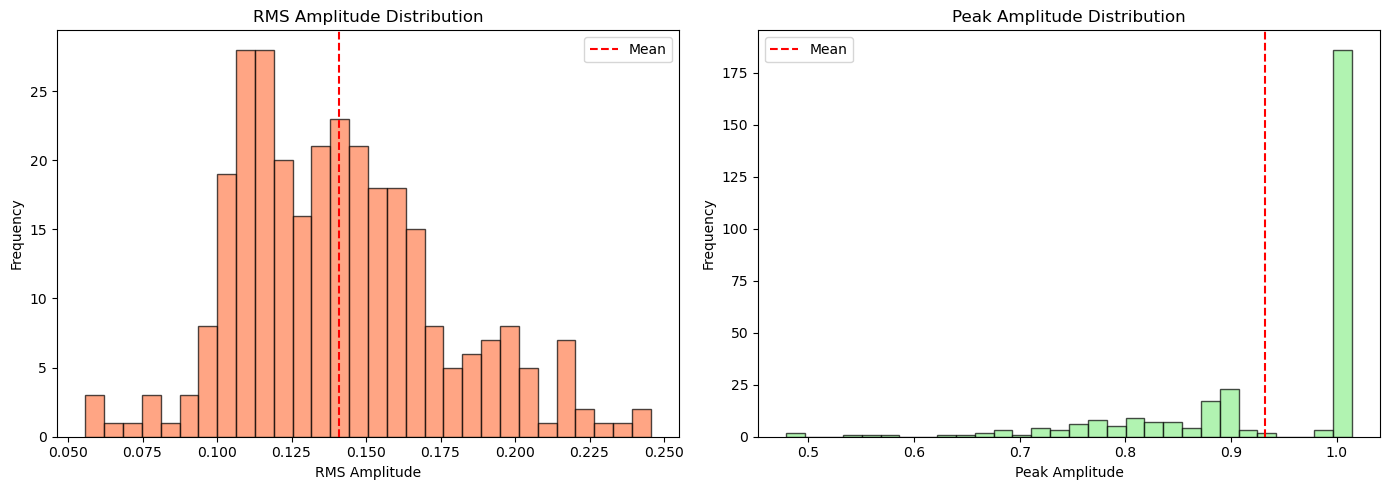

- 189 files dengan clipping potential


In [15]:
print("\nAmplitude/Volume Analysis:")
amplitudes_rms = []
amplitudes_peak = []

for fp in wav_files:
    y, sr = librosa.load(fp, sr=SR, mono=True)
    rms = np.sqrt(np.mean(y**2))
    peak = np.max(np.abs(y))
    amplitudes_rms.append(rms)
    amplitudes_peak.append(peak)

print(f"- RMS - Mean: {np.mean(amplitudes_rms):.4f}, Std: {np.std(amplitudes_rms):.4f}")
print(f"- Peak - Mean: {np.mean(amplitudes_peak):.4f}, Std: {np.std(amplitudes_peak):.4f}")

# Visualisasi
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(amplitudes_rms, bins=30, edgecolor='black', alpha=0.7, color='coral')
axes[0].set_xlabel('RMS Amplitude')
axes[0].set_ylabel('Frequency')
axes[0].set_title('RMS Amplitude Distribution')
axes[0].axvline(np.mean(amplitudes_rms), color='red', linestyle='--', label='Mean')
axes[0].legend()

axes[1].hist(amplitudes_peak, bins=30, edgecolor='black', alpha=0.7, color='lightgreen')
axes[1].set_xlabel('Peak Amplitude')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Peak Amplitude Distribution')
axes[1].axvline(np.mean(amplitudes_peak), color='red', linestyle='--', label='Mean')
axes[1].legend()

plt.tight_layout()
plt.show()

# Cek apakah perlu normalisasi volume
low_volume = sum(1 for rms in amplitudes_rms if rms < 0.01)
high_volume = sum(1 for peak in amplitudes_peak if peak > 0.95)
if low_volume > 0:
    print(f"- {low_volume} files dengan volume sangat rendah")
if high_volume > 0:
    print(f"- {high_volume} files dengan clipping potential")

### **Audio Feature (Mel-Spectogram)**


Sample Mel-Spectrogram per Emotion:


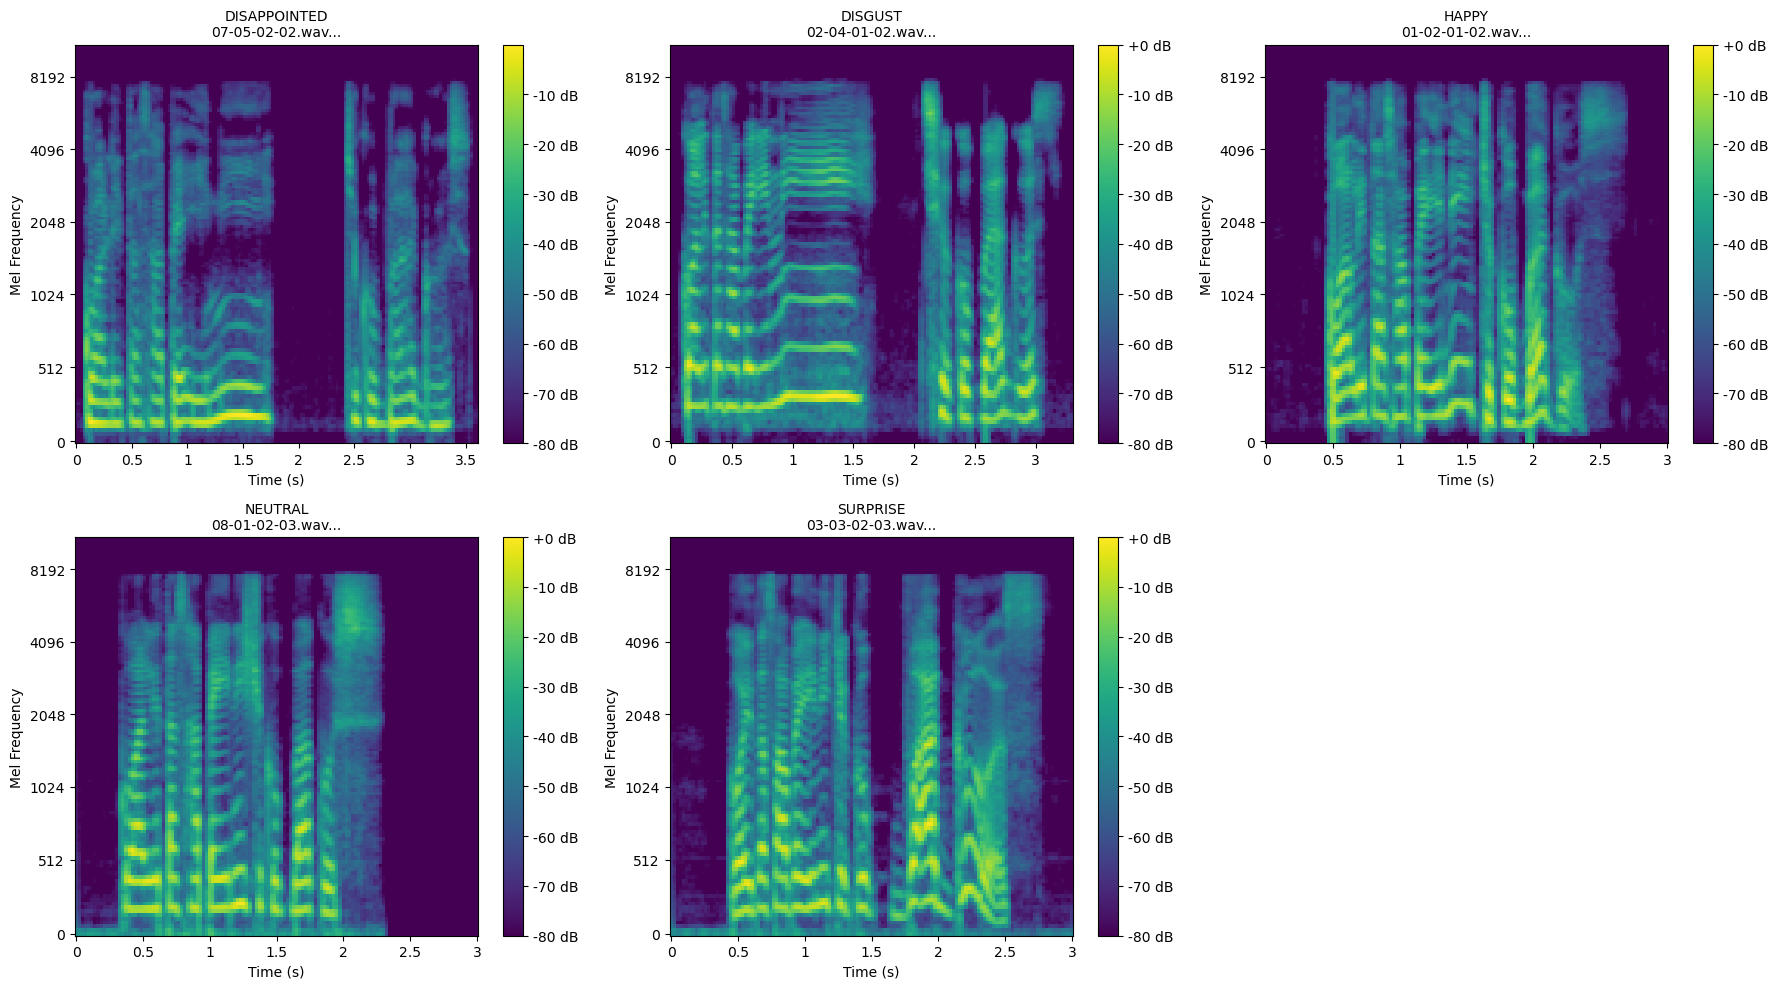

In [16]:
print("\nSample Mel-Spectrogram per Emotion:")

# Pilih 1 sample random per kelas
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, emotion in enumerate(sorted(label_map.values())):
    # Cari file dengan emotion tertentu
    files_emotion = [fp for fp in wav_files if label_from_filename(fp) == emotion]
    if not files_emotion:
        continue
    
    sample_file = random.choice(files_emotion)
    y, sr = librosa.load(sample_file, sr=SR, mono=True)
    
    # Compute mel-spectrogram
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=N_FFT, 
                                        hop_length=HOP_LENGTH, n_mels=N_MELS)
    log_mel = librosa.power_to_db(mel, ref=np.max)
    
    # Plot
    img = librosa.display.specshow(log_mel, sr=sr, hop_length=HOP_LENGTH, 
                                    x_axis='time', y_axis='mel', ax=axes[idx], cmap='viridis')
    axes[idx].set_title(f'{emotion.upper()}\n{os.path.basename(sample_file)[:20]}...', fontsize=10)
    axes[idx].set_xlabel('Time (s)')
    axes[idx].set_ylabel('Mel Frequency')
    fig.colorbar(img, ax=axes[idx], format='%+2.0f dB')

# Hide last subplot if odd number of classes
if len(label_map) < 6:
    axes[-1].axis('off')

plt.tight_layout()
plt.show()


Mel-Spectrogram's statistics per Class:


C:\Users\loq\AppData\Local\Temp\ipykernel_21036\1881659574.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[idx].boxplot(data, labels=sorted(label_map.values()), patch_artist=True)
C:\Users\loq\AppData\Local\Temp\ipykernel_21036\1881659574.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[idx].boxplot(data, labels=sorted(label_map.values()), patch_artist=True)
C:\Users\loq\AppData\Local\Temp\ipykernel_21036\1881659574.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[idx].boxplot(data, labels=sorted(label_map.values()), patch_artist=True)


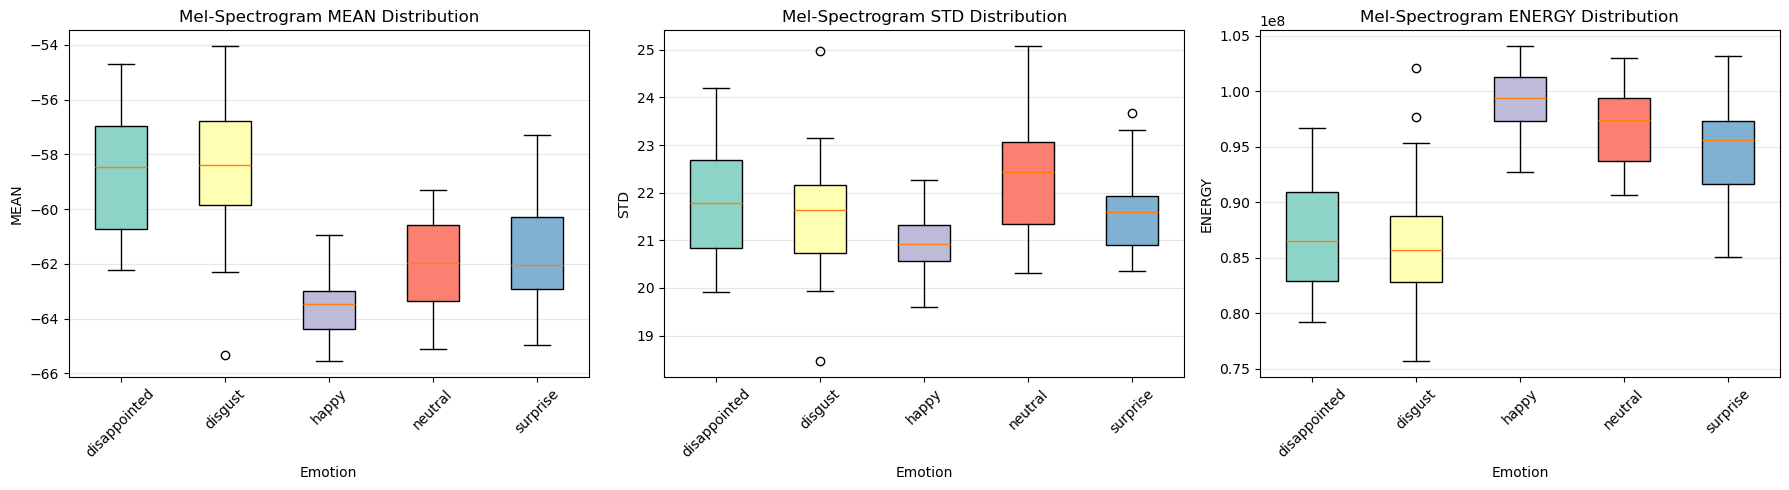


   DISAPPOINTED:
- Mean:   -58.71 ± 2.13
- Std:    21.81 ± 1.24
- Energy: 8.70e+07

   DISGUST:
- Mean:   -58.53 ± 2.75
- Std:    21.59 ± 1.33
- Energy: 8.64e+07

   HAPPY:
- Mean:   -63.50 ± 1.14
- Std:    20.99 ± 0.66
- Energy: 9.91e+07

   NEUTRAL:
- Mean:   -62.14 ± 1.66
- Std:    22.45 ± 1.33
- Energy: 9.68e+07

   SURPRISE:
- Mean:   -61.71 ± 1.97
- Std:    21.60 ± 0.93
- Energy: 9.48e+07


In [24]:
print("\nMel-Spectrogram's statistics per Class:")

mel_stats = {emotion: {'mean': [], 'std': [], 'energy': []} for emotion in label_map.values()}

# Sampling untuk efisiensi
sample_size = min(20, len(wav_files) // len(label_map))  # 20 sample per kelas
for emotion in label_map.values():
    files_emotion = [fp for fp in wav_files if label_from_filename(fp) == emotion]
    sampled_files = random.sample(files_emotion, min(sample_size, len(files_emotion)))
    
    for fp in sampled_files:
        spec = file_to_log_mel(fp)
        mel_stats[emotion]['mean'].append(np.mean(spec))
        mel_stats[emotion]['std'].append(np.std(spec))
        mel_stats[emotion]['energy'].append(np.sum(spec**2))

# Visualisasi
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, metric in enumerate(['mean', 'std', 'energy']):
    data = [mel_stats[emotion][metric] for emotion in sorted(label_map.values())]
    bp = axes[idx].boxplot(data, labels=sorted(label_map.values()), patch_artist=True)
    
    # Color boxes
    colors = plt.cm.Set3(range(len(label_map)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    axes[idx].set_ylabel(metric.upper())
    axes[idx].set_xlabel('Emotion')
    axes[idx].set_title(f'Mel-Spectrogram {metric.upper()} Distribution')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
for emotion in sorted(label_map.values()):
    print(f"\n   {emotion.upper()}:")
    print(f"- Mean:   {np.mean(mel_stats[emotion]['mean']):.2f} ± {np.std(mel_stats[emotion]['mean']):.2f}")
    print(f"- Std:    {np.mean(mel_stats[emotion]['std']):.2f} ± {np.std(mel_stats[emotion]['std']):.2f}")
    print(f"- Energy: {np.mean(mel_stats[emotion]['energy']):.2e}")


Average Mel-Spectrogram per Emotion:


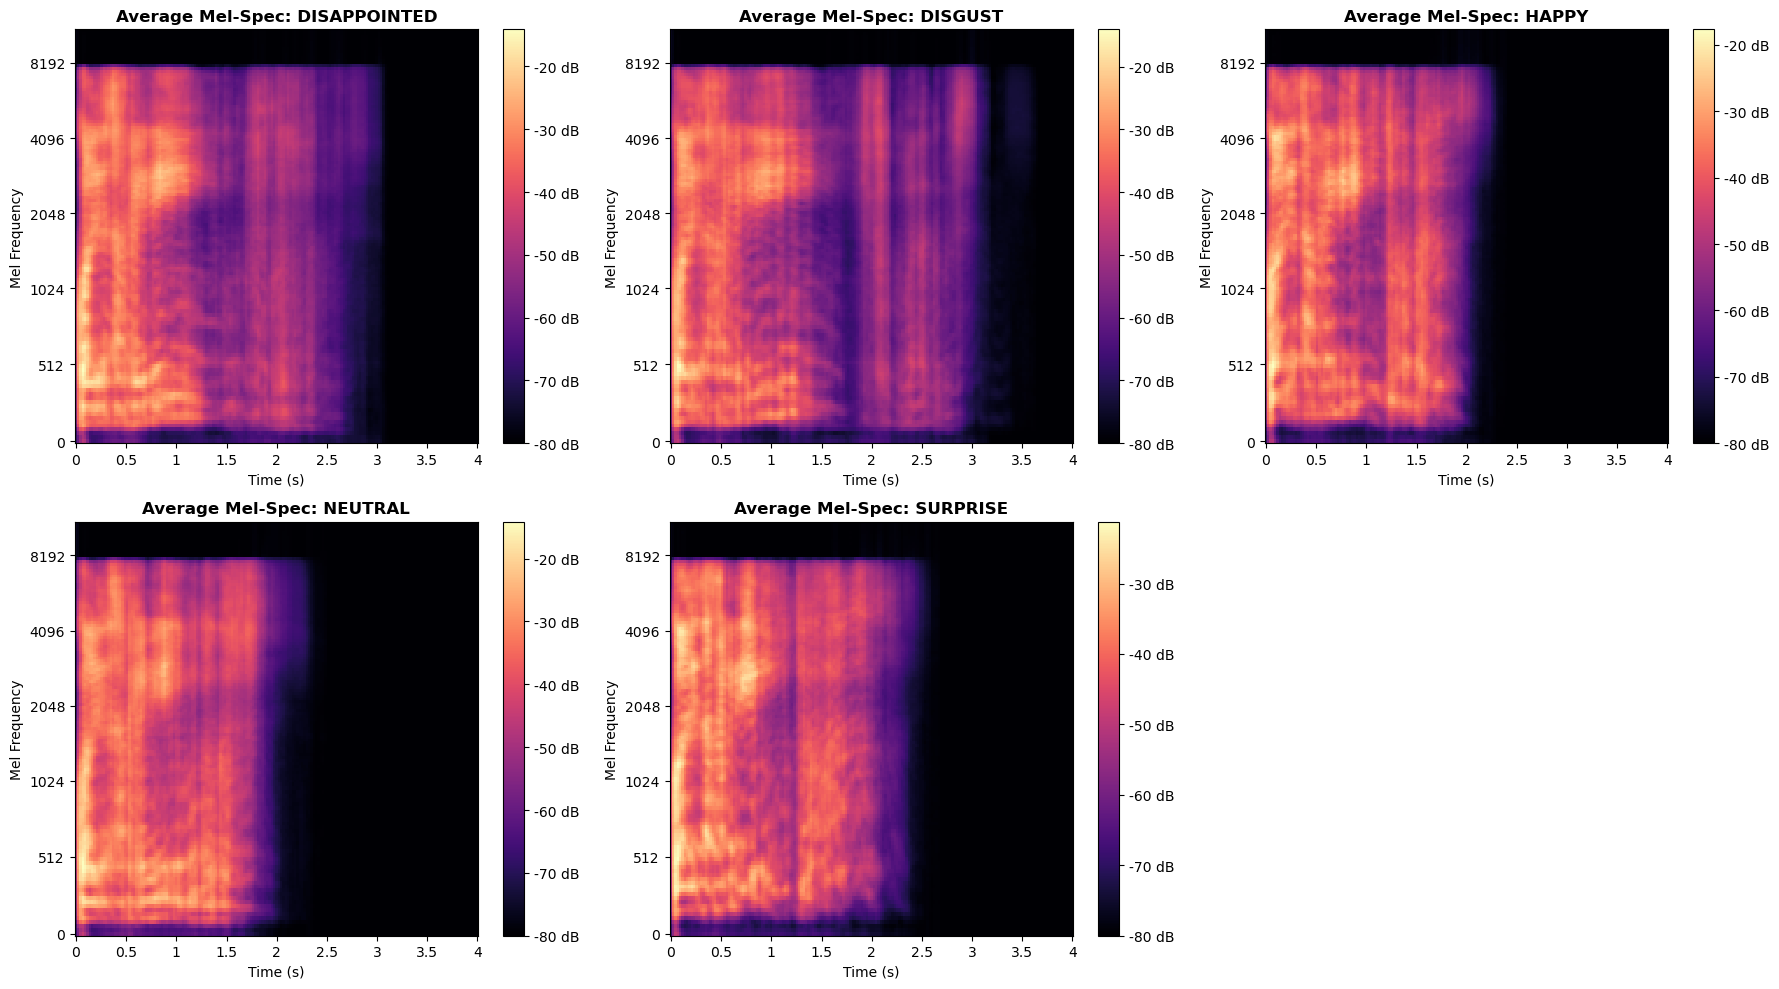

In [18]:
print("\nAverage Mel-Spectrogram per Emotion:")

# Compute average mel-spec per kelas
avg_mels = {}
for emotion in label_map.values():
    files_emotion = [fp for fp in wav_files if label_from_filename(fp) == emotion]
    specs = []
    for fp in files_emotion[:30]:  # Max 30 files per kelas untuk efisiensi
        spec = file_to_log_mel(fp)
        # Ensure same time dimension
        if spec.shape[1] >= 173:
            spec = spec[:, :173]
        else:
            spec = np.pad(spec, ((0, 0), (0, 173 - spec.shape[1])), mode='constant')
        specs.append(spec)
    avg_mels[emotion] = np.mean(specs, axis=0)

# Visualisasi
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, emotion in enumerate(sorted(label_map.values())):
    img = librosa.display.specshow(avg_mels[emotion], sr=SR, hop_length=HOP_LENGTH,
                                    x_axis='time', y_axis='mel', ax=axes[idx], cmap='magma')
    axes[idx].set_title(f'Average Mel-Spec: {emotion.upper()}', fontweight='bold')
    axes[idx].set_xlabel('Time (s)')
    axes[idx].set_ylabel('Mel Frequency')
    fig.colorbar(img, ax=axes[idx], format='%+2.0f dB')

if len(label_map) < 6:
    axes[-1].axis('off')

plt.tight_layout()
plt.show()

### **Pitch & Spectral Features**

C:\Users\loq\AppData\Local\Temp\ipykernel_21036\4177271482.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0, 0].boxplot(data, labels=sorted(label_map.values()), patch_artist=True)
C:\Users\loq\AppData\Local\Temp\ipykernel_21036\4177271482.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0, 1].boxplot(data, labels=sorted(label_map.values()), patch_artist=True)
C:\Users\loq\AppData\Local\Temp\ipykernel_21036\4177271482.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 0].boxplot(data, labels=sorted(label_map.values()), patch_artist=True)
C:\Users\loq\AppData\Local\Temp\ipyke

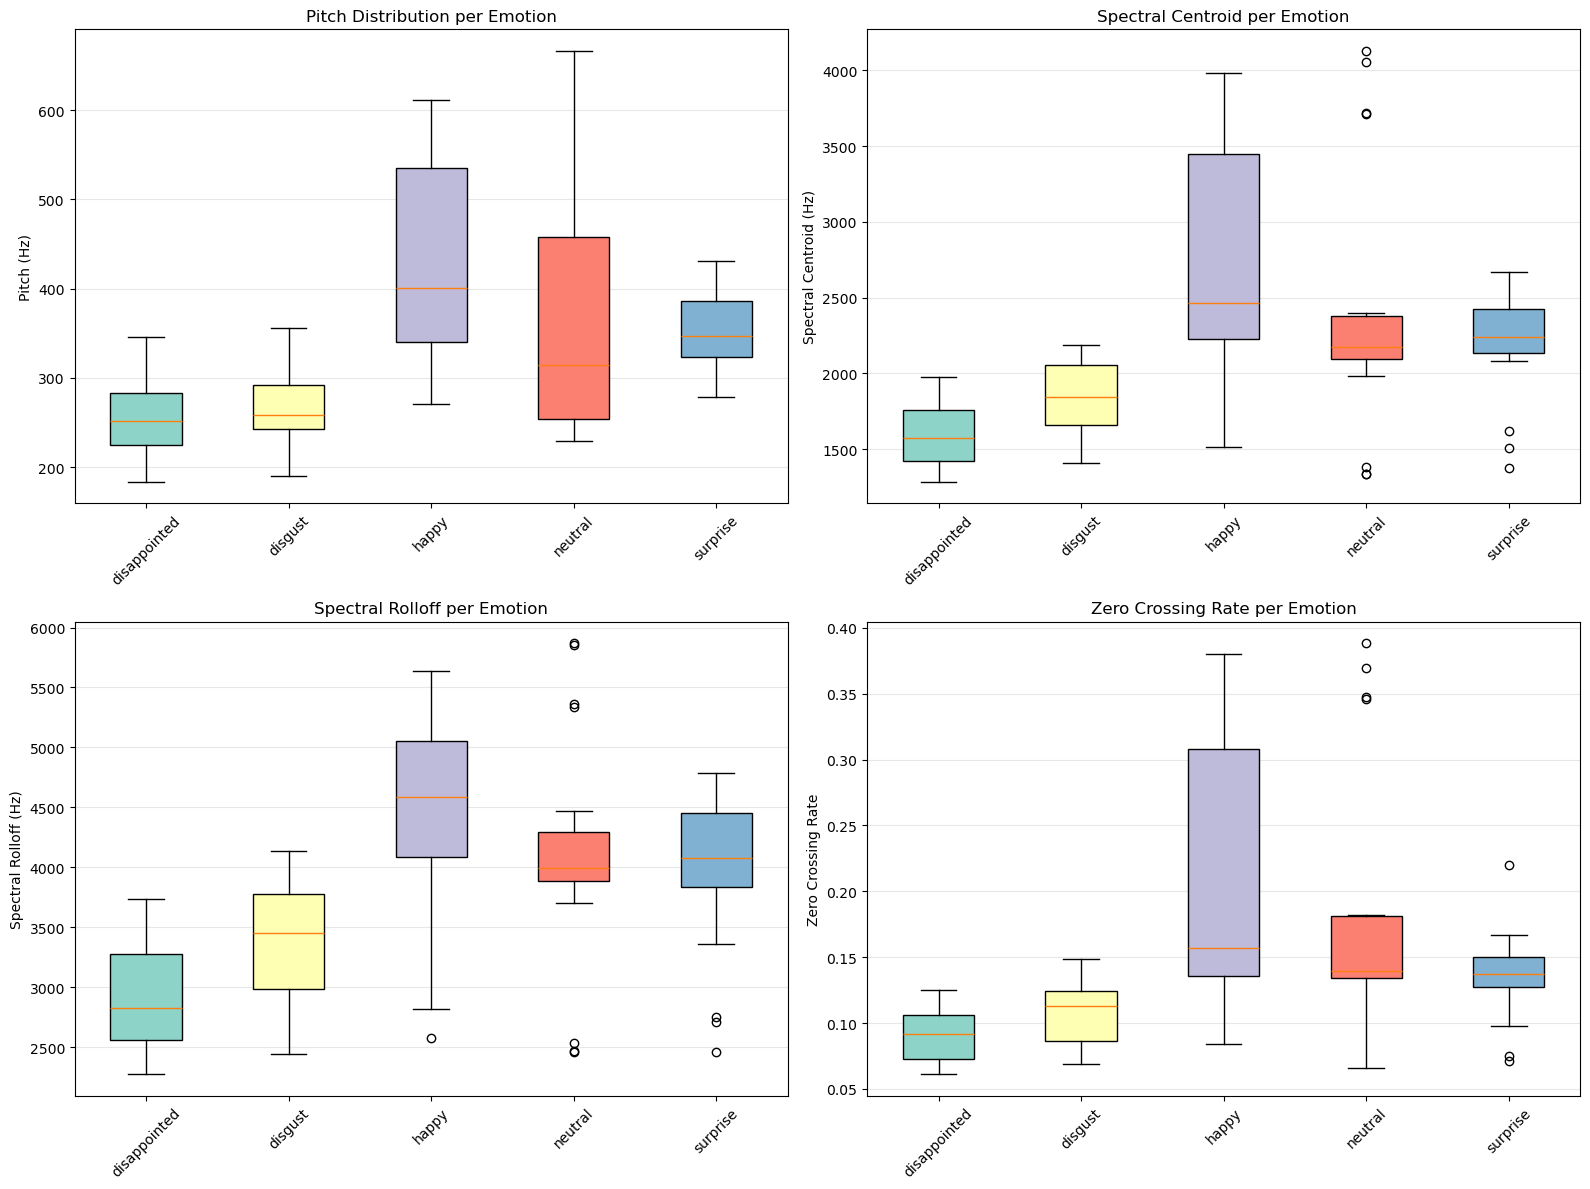

In [25]:
pitch_stats = {emotion: [] for emotion in label_map.values()}
spectral_centroid = {emotion: [] for emotion in label_map.values()}
spectral_rolloff = {emotion: [] for emotion in label_map.values()}
zero_crossing = {emotion: [] for emotion in label_map.values()}

for emotion in label_map.values():
    files_emotion = [fp for fp in wav_files if label_from_filename(fp) == emotion]
    sampled_files = random.sample(files_emotion, min(20, len(files_emotion)))
    
    for fp in sampled_files:
        y, sr = librosa.load(fp, sr=SR, mono=True)
        
        # Pitch (fundamental frequency)
        pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
        pitch = []
        for t in range(pitches.shape[1]):
            index = magnitudes[:, t].argmax()
            pitch_val = pitches[index, t]
            if pitch_val > 0:
                pitch.append(pitch_val)
        if pitch:
            pitch_stats[emotion].append(np.median(pitch))
        
        # Spectral features
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
        spec_roll = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
        zcr = librosa.feature.zero_crossing_rate(y)[0]
        
        spectral_centroid[emotion].append(np.mean(spec_cent))
        spectral_rolloff[emotion].append(np.mean(spec_roll))
        zero_crossing[emotion].append(np.mean(zcr))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Pitch
data = [pitch_stats[emotion] for emotion in sorted(label_map.values())]
bp = axes[0, 0].boxplot(data, labels=sorted(label_map.values()), patch_artist=True)
colors = plt.cm.Set3(range(len(label_map)))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
axes[0, 0].set_ylabel('Pitch (Hz)')
axes[0, 0].set_title('Pitch Distribution per Emotion')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# Spectral Centroid
data = [spectral_centroid[emotion] for emotion in sorted(label_map.values())]
bp = axes[0, 1].boxplot(data, labels=sorted(label_map.values()), patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
axes[0, 1].set_ylabel('Spectral Centroid (Hz)')
axes[0, 1].set_title('Spectral Centroid per Emotion')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# Spectral Rolloff
data = [spectral_rolloff[emotion] for emotion in sorted(label_map.values())]
bp = axes[1, 0].boxplot(data, labels=sorted(label_map.values()), patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
axes[1, 0].set_ylabel('Spectral Rolloff (Hz)')
axes[1, 0].set_title('Spectral Rolloff per Emotion')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# Zero Crossing Rate
data = [zero_crossing[emotion] for emotion in sorted(label_map.values())]
bp = axes[1, 1].boxplot(data, labels=sorted(label_map.values()), patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
axes[1, 1].set_ylabel('Zero Crossing Rate')
axes[1, 1].set_title('Zero Crossing Rate per Emotion')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## **Preprocessing**

In [95]:
X_list = []
y_list = []
X_files = []
skipped = []

for fp in wav_files:
    lbl = label_from_filename(fp)
    if lbl == 'unknown':
        skipped.append(fp)
        continue
    try:
        spec = file_to_log_mel(fp)        # (n_mels, t_frames)
        X_list.append(spec)
        y_list.append(lbl)
        X_files.append(fp)
    except Exception as e:
        skipped.append(fp)
        print("Skipped", fp, ":", e)

if len(X_list) == 0:
    raise RuntimeError("No valid spectrograms. Check filenames and label_map.")

# Stack and add channel dim for Conv2D
X = np.stack(X_list, axis=0).astype(np.float32)   # (N, n_mels, t_frames)
X = np.expand_dims(X, -1)                         # (N, n_mels, t_frames, 1)
y = np.array(y_list)

print("Built dataset:", X.shape, "labels:", Counter(y))
if skipped:
    print("Skipped files:", len(skipped), "examples:", skipped[:5])

Built dataset: (300, 128, 173, 1) labels: Counter({'neutral': 60, 'happy': 60, 'surprise': 60, 'disgust': 60, 'disappointed': 60})


In [96]:
# Encode labels -> expect 5 classes
le = LabelEncoder()
y_enc = le.fit_transform(y)
print("Classes found:", le.classes_, "count:", len(le.classes_))
if len(le.classes_) != 5:
    print("Warning: expected 5 emotion classes. Verify label_map and filenames.")

Classes found: ['disappointed' 'disgust' 'happy' 'neutral' 'surprise'] count: 5


### **Splitting**

In [97]:
def group_key(path):
    fname = os.path.basename(path)
    return fname.replace('_aug', '').replace('.wav', '')

groups = np.array([group_key(fp) for fp in X_files])
uniq_groups, group_idx = np.unique(groups, return_inverse=True)

# Label per grup (pastikan konsisten)
group_labels = np.array([y_enc[groups == g][0] for g in uniq_groups])

# Stratified split: 20% test, sisanya train/val 50:50
g_train_val, g_test, _, y_g_test = train_test_split(
    uniq_groups, group_labels, test_size=0.20, stratify=group_labels, random_state=RANDOM_STATE
)
g_train, g_val, _, _ = train_test_split(
    g_train_val, group_labels[np.isin(uniq_groups, g_train_val)], 
    test_size=0.25, stratify=group_labels[np.isin(uniq_groups, g_train_val)], random_state=RANDOM_STATE
)

train_mask = np.isin(groups, g_train)
val_mask   = np.isin(groups, g_val)
test_mask  = np.isin(groups, g_test)

X_train, y_train = X[train_mask], y_enc[train_mask]
X_val,   y_val   = X[val_mask],   y_enc[val_mask]
X_test,  y_test  = X[test_mask],  y_enc[test_mask]

print("Distribusi per split:")
print("train:", Counter(y_train), "total:", len(y_train))
print("val  :", Counter(y_val),   "total:", len(y_val))
print("test :", Counter(y_test),  "total:", len(y_test))

Distribusi per split:
train: Counter({0: 40, 4: 39, 2: 38, 3: 32, 1: 31}) total: 180
val  : Counter({1: 17, 3: 16, 2: 10, 4: 9, 0: 8}) total: 60
test : Counter({3: 12, 4: 12, 1: 12, 2: 12, 0: 12}) total: 60


### **Normalization**

In [98]:
# NORMALISASI PER-FREQUENCY
# mean/std per mel-band (axis 0=batch, 2=time, 3=channel)
mean_freq = np.mean(X_train, axis=(0, 2, 3), keepdims=True)  # (1, n_mels, 1, 1)
std_freq  = np.std(X_train, axis=(0, 2, 3), keepdims=True) + EPS

X_train = (X_train - mean_freq) / std_freq
X_val   = (X_val   - mean_freq) / std_freq
X_test  = (X_test  - mean_freq) / std_freq

print("Normalisasi per-freq OK. Train shape:", X_train.shape)

Normalisasi per-freq OK. Train shape: (180, 128, 173, 1)


In [ ]:
classes_unique = np.unique(y_train)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=classes_unique,
    y=y_train
) 
class_weights = {int(c): float(w) for c, w in zip(classes_unique, class_weights_array)}
print("Class weights:", class_weights)

Class weights: {0: 0.9, 1: 1.1612903225806452, 2: 0.9473684210526315, 3: 1.125, 4: 0.9230769230769231}


## **Modelling**

In [128]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print(f'Compute dtype: {policy.compute_dtype}')
print(f'Variable dtype: {policy.variable_dtype}')

Compute dtype: float16
Variable dtype: float32


In [129]:
class SpecAugment(layers.Layer):
    def __init__(self, freq_masks=2, time_masks=2, freq_max=18, time_max=30, **kwargs):
        super().__init__(**kwargs)
        self.freq_masks = freq_masks
        self.time_masks = time_masks
        self.freq_max = freq_max
        self.time_max = time_max

    def call(self, x, training=None):
        if not training:
            return x
        B = tf.shape(x)[0]; F = tf.shape(x)[1]; T = tf.shape(x)[2]
        d = x.dtype

        for _ in range(self.freq_masks):
            f = tf.random.uniform([], 0, self.freq_max, dtype=tf.int32)
            f0 = tf.random.uniform([], 0, F - f, dtype=tf.int32)
            mask = tf.concat([
                tf.ones([B, f0, T, 1], dtype=d),
                tf.zeros([B, f, T, 1], dtype=d),
                tf.ones([B, F - f0 - f, T, 1], dtype=d)
            ], axis=1)
            x = x * mask

        for _ in range(self.time_masks):
            t = tf.random.uniform([], 0, self.time_max, dtype=tf.int32)
            t0 = tf.random.uniform([], 0, T - t, dtype=tf.int32)
            mask = tf.concat([
                tf.ones([B, F, t0, 1], dtype=d),
                tf.zeros([B, F, t, 1], dtype=d),
                tf.ones([B, F, T - t0 - t, 1], dtype=d)
            ], axis=2)
            x = x * mask

        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "freq_masks": self.freq_masks,
            "time_masks": self.time_masks,
            "freq_max": self.freq_max,
            "time_max": self.time_max
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [130]:
data_augmentation = Sequential([
    layers.GaussianNoise(0.01),  # Noise injection
    layers.RandomContrast(0.2),  # Contrast perturbation
], name='data_augmentation')

In [137]:
input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))
print("Input shape:", input_shape, "Num classes:", num_classes)

model = Sequential([
    layers.Input(shape=input_shape),
    data_augmentation,
    # SpecAugment dengan intensitas lebih rendah
    SpecAugment(freq_masks=1, time_masks=1, freq_max=10, time_max=15),
    
    # Block 1: Ekstraksi fitur low-level
    layers.Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Dropout(0.25),
    
    # Block 2: Ekstraksi fitur mid-level
    layers.Conv2D(128, (3,3), padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(128, (3,3), padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Dropout(0.25),
    
    # Block 3: Ekstraksi fitur high-level
    layers.Conv2D(256, (3,3), padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(256, (3,3), padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Dropout(0.3),
    
    # Global Average Pooling (lebih baik dari Flatten)
    layers.GlobalAveragePooling2D(),
    
    # Dense layers dengan regularisasi
    layers.Dense(256, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    
    layers.Dense(128, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    
    # Output layer
    layers.Dense(num_classes, activation='softmax', dtype='float32')
])

model.summary()

Input shape: (128, 173, 1) Num classes: 5
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, 128, 173, 1)      0         
 al)                                                             
                                                                 
 spec_augment_8 (SpecAugment  (None, 128, 173, 1)      0         
 )                                                               
                                                                 
 conv2d_54 (Conv2D)          (None, 128, 173, 64)      640       
                                                                 
 batch_normalization_64 (Bat  (None, 128, 173, 64)     256       
 chNormalization)                                                
                                                                 
 activation_64 (Activation)  (None, 128, 173, 64)      0         
            

In [138]:
optimizer = optimizers.Adam(
    learning_rate=3e-4,
    clipnorm=1.0  # Prevent exploding gradients
)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

ckpt_path = "cnn_best.h5"

def lr_schedule(epoch, lr):
    """Cosine annealing schedule"""
    initial_lr = 3e-4
    min_lr = 1e-6
    decay_epochs = 60
    if epoch < decay_epochs:
        cos_inner = math.pi * epoch / decay_epochs
        return min_lr + 0.5 * (initial_lr - min_lr) * (1 + math.cos(cos_inner))
    return min_lr

cbs = [
    callbacks.ModelCheckpoint(
        ckpt_path, 
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max', 
        verbose=1
    ),
    callbacks.EarlyStopping(
        monitor='val_accuracy', 
        patience=20,  # Increased patience
        mode='max', 
        restore_best_weights=True, 
        verbose=1
    ),
    callbacks.LearningRateScheduler(lr_schedule, verbose=1),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
]

In [171]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=100,
    callbacks=cbs,
    class_weight=class_weights,
    verbose=1,
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0003.
Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 0.7449 - accuracy: 0.9722
Epoch 1: val_accuracy did not improve from 0.85000
6/6 [==============================] - 3s 439ms/step - loss: 0.7449 - accuracy: 0.9722 - val_loss: 4.2023 - val_accuracy: 0.5167 - lr: 3.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00029979511544580873.
Epoch 2/100
6/6 [==============================] - ETA: 0s - loss: 0.7300 - accuracy: 0.9833
Epoch 2: val_accuracy did not improve from 0.85000
6/6 [==============================] - 2s 254ms/step - loss: 0.7300 - accuracy: 0.9833 - val_loss: 4.0530 - val_accuracy: 0.5333 - lr: 2.9980e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0002991810233575568.
Epoch 3/100
6/6 [==============================] - ETA: 0s - loss: 0.7665 - accuracy: 0.9667
Epoch 3: val_accuracy did not improve from 0.85000
6/6 [==============================] - 1s 245ms/st

In [172]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

2/2 [==============================] - 0s 25ms/step


## **Evaluation**

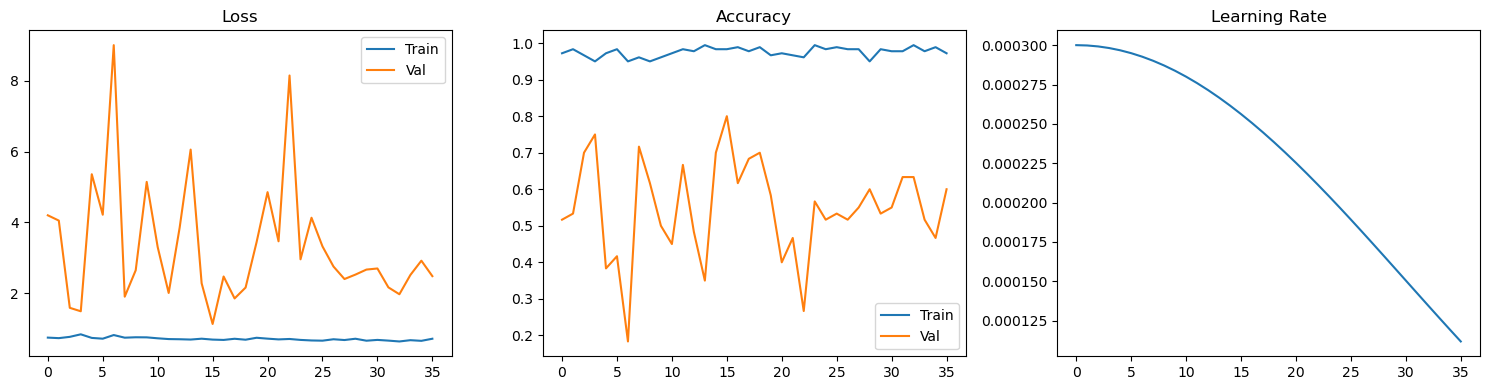

In [173]:
# loss graph
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()

plt.subplot(1,3,2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

# Learning rate history (dari callback)
if 'lr' in history.history:
    plt.subplot(1,3,3)
    plt.plot(history.history['lr'])
    plt.title('Learning Rate')
    plt.tight_layout()
plt.show()

Test Accuracy: 0.7833
Test Precision: 0.7935
Test Recall: 0.7833
Test F1-Score: 0.7762
Classification report:
              precision    recall  f1-score   support

disappointed       0.60      0.50      0.55        12
     disgust       0.78      0.58      0.67        12
       happy       0.67      1.00      0.80        12
     neutral       0.92      1.00      0.96        12
    surprise       1.00      0.83      0.91        12

    accuracy                           0.78        60
   macro avg       0.79      0.78      0.78        60
weighted avg       0.79      0.78      0.78        60



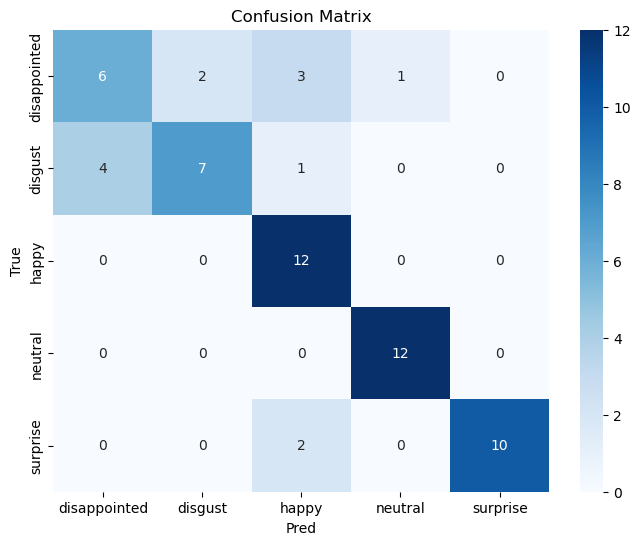

In [174]:
accuracy_score_val = accuracy_score(y_test, y_pred)
precision_score_val = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall_score_val = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1_score_val = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Test Accuracy: {accuracy_score_val:.4f}")
print(f"Test Precision: {precision_score_val:.4f}")
print(f"Test Recall: {recall_score_val:.4f}")
print(f"Test F1-Score: {f1_score_val:.4f}")
print("Classification report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.ylabel('True'); plt.xlabel('Pred')
plt.title('Confusion Matrix')
plt.show()